# Imports

In [1]:
import pandas as pd
import ERIKS_forecasting as EF
import matplotlib.pyplot as plt

# Replicate Notebook 1, stage 3 and Notebook 2, stages 1 and 2, with Delivery Line data instead

We now know, from Hans Rijs at Sealing and Polymer, that Slim4 uses delivery line data, for demand. It uses this plus internal consumption, which the SalesOrderLine table in TED doesn't account for currently. Hans will provide a source analysis to Anil, of the MSEG table in SAP, which contains the demand that Slim4 sees. 

But for now, let's see how well the delivery line data matches with Johan's data from Slim4. Previously we had around 95k/122k rows match exactly on order quantity and number of orders. That's roughly 78%. 

# Notebook 1 - Import data

In [2]:
df_sp = pd.read_csv(r"Data\Sealing_Polymer_Data_Trimmed_1_July.csv", encoding = "ISO-8859-1")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
df_sp = df_sp.iloc[1:]
print (f'Number of rows = {len(df_sp)}')
df_sp.head()

Number of rows = 28438


C:\Users\shahe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2,7,8,9,11,12,13,14,15,16,17,18,19,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,63,67,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,112,113,114,115,116,117,118,119,120,121,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-2-a7e2104745c8>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Item_goods_group,Article_Prod_Group_EN01,Article,Article_Description,Self_Article_Group_5,Art_Vest_Level_Planning_Profile,Self_Position_Type_Group,Art_Vest_Level_Ordering_Point,Art_Vest_Level_Security_Stock,Art_Vest_Level_Total_Inventory,Article_Basic_Qty_Number_Unit,Art_Vest_Level_Price_Unit,Art_Vest_Level_Gem_Price,Art_Vest_Deprecated_Index_Number,Level_Auto_Number_Order,Art_Level_Min_Series_Size,Art_Vest_Rounding_Value,Art_Vest_Scheduled_Delivery_Time,Art_Vest_Consumption_Last_Year,Art_Vest_Avg_Consumption_Per_Month,Self_Quantity,Stock_Values,Call_Off_Contracts_Total,Customer_Orders_End_Total,Orders_03_19,Orders_04_19,Orders_05_19,Orders_06_19,Orders_07_19,Orders_08_19,Orders_09_19,Orders_10_19,Orders_11_19,Orders_12_19,Orders_01_20,Orders_02_20,Orders_03_20,Purchase_Orders_End_Total,Purchase_Orders_03_19,Purchase_Orders_04_19,Purchase_Orders_05_19,Purchase_Orders_06_19,Purchase_Orders_07_19,Purchase_Orders_08_19,Purchase_Orders_09_19,Purchase_Orders_10_19,Purchase_Orders_11_19,Purchase_Orders_12_19,Purchase_Orders_01_20,Purchase_Orders_02_20,Consumption_Value_Grand_Total,Consumption_Total_03_19,Consumption_Total_04_19,Consumption_Total_05_19,Consumption_Total_06_19,Consumption_Total_07_19,Consumption_Total_08_19,Consumption_Total_09_19,Consumption_Total_10_19,Consumption_Total_11_19,Consumption_Total_12_19,Consumption_Total_01_20,Consumption_Total_02_20,Consumption_Total_03_20,Requirements_Plan_Total,Requirements_Plan_03_20,Requirements_Plan_04_20,Requirements_Plan_05_20,Requirements_Plan_06_20,Requirements_Plan_07_20,Requirements_Plan_08_20,Requirements_Plan_09_20,Requirements_Plan_10_20,Requirements_Plan_11_20,Requirements_Plan_12_20,Requirements_Plan_01_21,Requirements_Plan_02_21,Requirements_Plan_03_21,On_Call_Contracts_05_19,On_Call_Contracts_06_19,On_Call_Contracts_07_19,On_Call_Contracts_08_19,On_Call_Contracts_09_19,On_Call_Contracts_10_19,On_Call_Contracts_11_19,On_Call_Contracts_12_19,On_Call_Contracts_01_20,On_Call_Contracts_02_20,On_Call_Contracts_03_20,On_Call_Contracts_04_20,On_Call_Contracts_05_20,On_Call_Contracts_06_20,On_Call_Contracts_07_20,On_Call_Contracts_08_20,On_Call_Contracts_09_20,On_Call_Contracts_11_20,On_Call_Contracts_12_20,On_Call_Contracts_01_21,On_Call_Contracts_02_21,On_Call_Contracts_03_21,04_21,10_21,12_21,02_22,Consumption,Forecast_Available,Sales_Last_Six_Months_LSM,Cust_Spec_No_Sales_LSM,Iron_Stock,Iron_No_Sales_Last_3_Months_Not_Cust_Spec,Cust_Spec_Or_Bound_And_Iron_Stock,Delivery_Time_Times_Consumption,Avg_Consumption_Per_Month,Standard_Deviation_Per_Month,CV_2,ADI,No_Forecast_No_Consumption,Component_Kitting_SKU,Singular,Smooth,Intermittent,Erratic,Lumpy,Demand_Profile
1,10510100 (Celr.strip Neopreen),22 (Moulded Rubber),10000000,Prof.CR FEST cel-zelfkl zwart 10x2 L=20,03 (Gangbare voorraad),VV1,NORM (Normale positie),2591,0,2320,m (Meter),1,0.12,0,TRUE,1800,1800,49,8187.096774,682.2580645,"2,320", 281.79,NaN,123,13,6,11,4,10,5,16,17,10,3,18,10,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,2,NaN,"11,180",960,380,660,200,560,200,"1,040","2,120","2,260",480,"1,500",820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN, 982,No,LSM=1,-,-,-,-," 48,140",932,695,0.557,0,0,0,0,0,0,1,0,Erratic
2,10510100 (Celr.strip Neopreen),22 (Moulded Rubber),10000001,Prof.CR FEST cel-zelfkl zwart 10x3 L=20,03 (Gangbare voorraad),VV1,NORM (Normale positie),3857,0,4900,m (Meter),1,0.15,0,TRUE,4000,1800,49,16717.41935,1393.11828,"4,900", 723.97,NaN,132,16,14,8,8,12,7,7,22,13,1,11,13,NaN,4,1,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,1,NaN,"21,840","3,120","3,260",660,"1,460","1,280",140,"4,120","3,140","1,400",20,"2,020","1,220",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN," 2,508",No,LSM=1,-,-,-,-," 122,873",1820,1321,0.527,0,0,0,0,0,0,1,0,Erratic
3,10510100 (Celr.strip Neopreen),22 (

# Notebook 1 - Create SQL query

Structure of SQL output:
| MaterialNo | OrderQuantity | SalesOrderLineCreationDate | 

Only difference now, is that this data should come from SalesOrderLineDelivery, and in future, the MSEG table in TED when implemented.

In [3]:
df_sp.Article = df_sp.Article.astype(str) 
Article_numbers = df_sp.Article.unique()
print (len(Article_numbers))
sql_list = "("
for x in range(len(Article_numbers)):
    sql_list += "'NL-0000000000" + str(Article_numbers[x]) + "'" + ", " 
sql_list = sql_list[:-2]
sql_list += ")"

script_SP_SKUs_delivery_line_data = f'SELECT MaterialNo, DeliveryBaseUnitQuantity, SalesOrderDeliveryLineCreationDate FROM [ed].[SalesOrderLineDelivery] where MaterialNo in {sql_list}'

EF.write_script_to_file(script_SP_SKUs_delivery_line_data, 'scripts\SP_SKUs_Delivery_Line_Query.txt')

28438


# Notebook 1 - Import TED data and clean

Ran this query in TED, got this file:

In [4]:
df_sp_sql = pd.read_csv(r"Data\TED_Data\SP_SKU_delivery_line_data_14_jan_21.csv")
df_sp_sql.head()

,MaterialNo,DeliveryBaseUnitQuantity,SalesOrderDeliveryLineCreationDate
0,NL-000000000011938131,1.0,2018-11-16
1,NL-000000000010014239,1.0,2019-02-01
2,NL-000000000011295548,1.0,2019-04-04
3,NL-000000000010020294,1.0,2019-09-05
4,NL-000000000010028242,1.0,2019-08-02


In [5]:
df_sp_sql['MaterialNo'] = df_sp_sql['MaterialNo'].str[13:] # Only run this cell once!
df_sp_sql['SalesOrderDeliveryLineCreationDate'] = pd.to_datetime(df_sp_sql['SalesOrderDeliveryLineCreationDate'])
df_sp_sql_group_by = df_sp_sql.groupby([pd.Grouper(key='SalesOrderDeliveryLineCreationDate', freq='MS'), 'MaterialNo'])
df_sp_sql_group_by_plus_counts = df_sp_sql_group_by.size().to_frame(name='SQL_counts')
df_sp_sql_group_by_plus_counts = df_sp_sql_group_by_plus_counts.join(df_sp_sql_group_by.agg({'DeliveryBaseUnitQuantity': 'sum'}).rename(columns={'DeliveryBaseUnitQuantity': 'SQL_OQ'})).reset_index()
df_sp_sql_group_by_plus_counts.head(n = 100)

,SalesOrderDeliveryLineCreationDate,MaterialNo,SQL_counts,SQL_OQ
0,2016-01-01,10023246,1,5500.0
1,2016-01-01,10023719,1,50.0
2,2016-02-01,10024352,1,100.0
3,2016-02-01,10024653,1,100.0
4,2016-02-01,10026686,1,100.0
...,...,...,...,...
95,2017-02-01,12395217,1,1000.0
96,2017-03-01,10026584,1,8.0
97,2017-03-01,10027192,1,200.0
98,2017-03-01,10027247,1,100.0


# Notebook 1 - Reformat SP data to compare against SQL

In [6]:
df_sp_order_quantities = df_sp[['Article',
                                'Orders_03_19', 
                                'Orders_04_19', 
                                'Orders_05_19',
                                'Orders_06_19',
                                'Orders_07_19',
                                'Orders_08_19',
                                'Orders_09_19',
                                'Orders_10_19',
                                'Orders_11_19',
                                'Orders_12_19',
                                'Orders_01_20',
                                'Orders_02_20',
                                'Consumption_Total_03_19',
                                'Consumption_Total_04_19',
                                'Consumption_Total_05_19',
                                'Consumption_Total_06_19',
                                'Consumption_Total_07_19',
                                'Consumption_Total_08_19',
                                'Consumption_Total_09_19',
                                'Consumption_Total_10_19',
                                'Consumption_Total_11_19',
                                'Consumption_Total_12_19',
                                'Consumption_Total_01_20',
                                'Consumption_Total_02_20']]
df_sp_order_quantities.head()

,Article,Orders_03_19,Orders_04_19,Orders_05_19,Orders_06_19,Orders_07_19,Orders_08_19,Orders_09_19,Orders_10_19,Orders_11_19,Orders_12_19,Orders_01_20,Orders_02_20,Consumption_Total_03_19,Consumption_Total_04_19,Consumption_Total_05_19,Consumption_Total_06_19,Consumption_Total_07_19,Consumption_Total_08_19,Consumption_Total_09_19,Consumption_Total_10_19,Consumption_Total_11_19,Consumption_Total_12_19,Consumption_Total_01_20,Consumption_Total_02_20
1,10000000,13,6,11,4,10,5,16,17,10,3,18,10,960,380,660,200,560,200,"1,040","2,120","2,260",480,"1,500",820
2,10000001,16,14,8,8,12,7,7,22,13,1,11,13,"3,120","3,260",660,"1,460","1,280",140,"4,120","3,140","1,400",20,"2,020","1,220"
3,10000003,9,8,5,7,4,4,4,8,9,8,13,5,440,500,240,400,420,220,320,"3,440","1,364",420,780,180
4,10000004,2,1,6,4,9,7,9,7,11,2,3,2,"1,200",600,800,"1,400","2,980","2,000","1,600","2,040","2,340",680,160,620
5,10000005,2,7,4,2,3,1,5,5,4,2,9,6,100,"6,200",140,"1,020",380,20,"1,180","1,240","1,340","5,080","5,300","1,220"


In [7]:
df_sp_sql_group_by_plus_counts.MaterialNo = df_sp_sql_group_by_plus_counts.MaterialNo.astype(str) 
df_sp_sql_group_by_plus_counts.SalesOrderDeliveryLineCreationDate = df_sp_sql_group_by_plus_counts.SalesOrderDeliveryLineCreationDate.astype(str) 
df_sp_order_quantities.Article = df_sp_order_quantities.Article.astype(str) 

def append_sp_data_to_sql_data(date, row, row_name_number_of_orders, row_name_amount_of_consumption):
    # This function uses a 28k and 460k dataframe. Needs to be sped up. Done now. 
    '''
    df_sp_sql_group_by_plus_counts.loc[
        (df_sp_sql_group_by_plus_counts['SalesOrderLineCreationDate'] == date) & 
        (df_sp_sql_group_by_plus_counts['MaterialNo'] == row['Article']), 'S_P_Count'] = row[row_name_number_of_orders]
    df_sp_sql_group_by_plus_counts.loc[
        (df_sp_sql_group_by_plus_counts['SalesOrderLineCreationDate'] == date) & 
        (df_sp_sql_group_by_plus_counts['MaterialNo'] == row['Article']), 'S_P_Consumption'] = row[row_name_amount_of_consumption]
    '''
    
    #To speed up code:
    # Put conditions in isin bools 
    bools_date_and_material_number_matching = df_sp_sql_group_by_plus_counts.SalesOrderDeliveryLineCreationDate.isin([date]) & df_sp_sql_group_by_plus_counts.MaterialNo.isin([row['Article']])
    df_sp_sql_group_by_plus_counts.loc[bools_date_and_material_number_matching, 'S_P_Count'] = row[row_name_number_of_orders]
    df_sp_sql_group_by_plus_counts.loc[bools_date_and_material_number_matching, 'S_P_Consumption'] = row[row_name_amount_of_consumption]
    

for index, row in df_sp_order_quantities.iterrows():
  
    append_sp_data_to_sql_data('2019-03-01', row, 'Orders_03_19', 'Consumption_Total_03_19')
    append_sp_data_to_sql_data('2019-04-01', row, 'Orders_04_19', 'Consumption_Total_04_19')
    append_sp_data_to_sql_data('2019-05-01', row, 'Orders_05_19', 'Consumption_Total_05_19')
    append_sp_data_to_sql_data('2019-06-01', row, 'Orders_06_19', 'Consumption_Total_06_19')
    append_sp_data_to_sql_data('2019-07-01', row, 'Orders_07_19', 'Consumption_Total_07_19')
    append_sp_data_to_sql_data('2019-08-01', row, 'Orders_08_19', 'Consumption_Total_08_19')
    append_sp_data_to_sql_data('2019-09-01', row, 'Orders_09_19', 'Consumption_Total_09_19')
    append_sp_data_to_sql_data('2019-10-01', row, 'Orders_10_19', 'Consumption_Total_10_19')
    append_sp_data_to_sql_data('2019-11-01', row, 'Orders_11_19', 'Consumption_Total_11_19')
    append_sp_data_to_sql_data('2019-12-01', row, 'Orders_12_19', 'Consumption_Total_12_19')
    append_sp_data_to_sql_data('2020-01-01', row, 'Orders_01_20', 'Consumption_Total_01_20')
    append_sp_data_to_sql_data('2020-02-01', row, 'Orders_02_20', 'Consumption_Total_02_20')
       
    print (f'Percentage complete: {100.0 * index / len(df_sp_order_quantities) }')

df_sp_sql_group_by_plus_counts.to_pickle(r'pickles/df_sp_sql_combined_delivery_lines_data.pkl')


C:\Users\shahe\anaconda3\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Percentage complete: 0.0035164216892889797
Percentage complete: 0.007032843378577959
Percentage complete: 0.010549265067866938
Percentage complete: 0.014065686757155919
Percentage complete: 0.017582108446444897
Percentage complete: 0.021098530135733876


KeyboardInterrupt: 

In [8]:
df_sp_sql_group_by_plus_counts = pd.read_pickle(r'pickles/df_sp_sql_combined_delivery_lines_data.pkl', compression='infer')


In [9]:
df_sp_sql_group_by_plus_counts_not_null = df_sp_sql_group_by_plus_counts[df_sp_sql_group_by_plus_counts.S_P_Count.notnull()]
df_sp_sql_group_by_plus_counts_not_null_10000001 = df_sp_sql_group_by_plus_counts_not_null[df_sp_sql_group_by_plus_counts_not_null['MaterialNo'] == '10000001']
df_sp_sql_group_by_plus_counts_not_null_10000001.head(n = 50)

,SalesOrderDeliveryLineCreationDate,MaterialNo,SQL_counts,SQL_OQ,S_P_Count,S_P_Consumption,(SP - SQL) Count,(SP - SQL) OQ,(SP - SQL) Count % diff of SP to SQL,(SP - SQL) OQ % diff of SP to SQL
157822,2019-03-01,10000001,10.0,1900.0,16,"3,120",6.0,1220.0,60.000000,64.210526
169092,2019-04-01,10000001,12.0,1920.0,14,"3,260",2.0,1340.0,16.666667,69.791667
180271,2019-05-01,10000001,12.0,2340.0,8,660,-4.0,-1680.0,-33.333333,-71.794872
191443,2019-06-01,10000001,6.0,1120.0,8,"1,460",2.0,340.0,33.333333,30.357143
201852,2019-07-01,10000001,8.0,680.0,12,"1,280",4.0,600.0,50.000000,88.235294
212754,2019-08-01,10000001,6.0,660.0,7,140,1.0,-520.0,16.666667,-78.787879
223009,2019-09-01,10000001,3.0,1040.0,7,"4,120",4.0,3080.0,133.333333,296.153846
233725,2019-10-01,10000001,21.0,2240.0,22,"3,140",1.0,900.0,4.761905,40.178571
244946,2019-11-01,10000001,17.0,2300.0,13,"1,400",-4.0,-900.0,-23.529412,-39.130435
264390,2020-01-01,10000001,8.0,1440.0,11,"2,020",3.0,580.0,37.500000,40.277778


Compare this data to this printscreen from notebook 1:
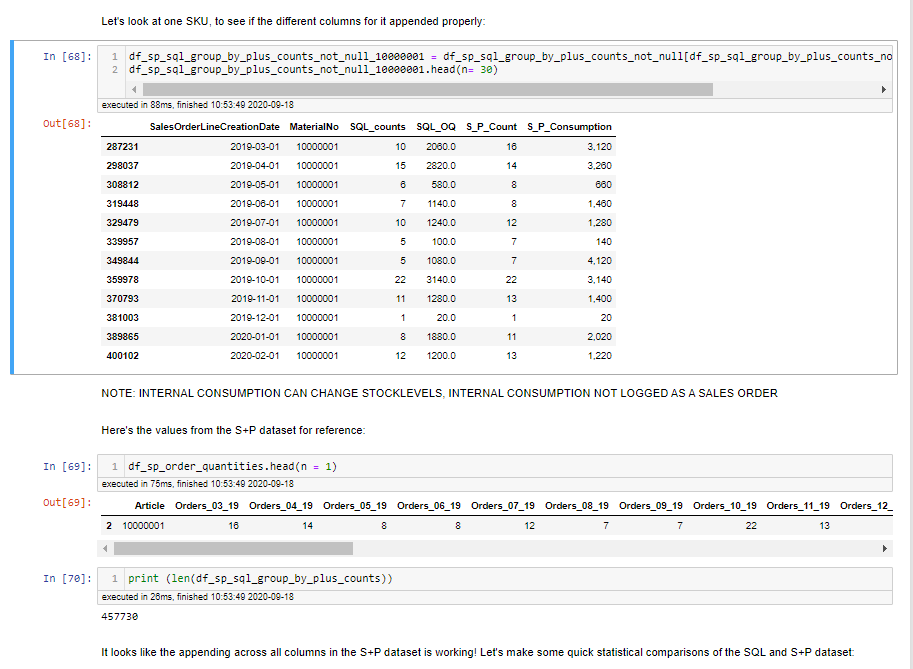    

We can see that using the delivery line data means we have different demand data now from SQL, but it's hard to tell if it's going to match the SP data better. Let's find out...

In [10]:
df_sp_sql_group_by_plus_counts.S_P_Count = df_sp_sql_group_by_plus_counts['S_P_Count'].astype(str).str.replace(",", "").astype(float)
df_sp_sql_group_by_plus_counts.S_P_Consumption = df_sp_sql_group_by_plus_counts['S_P_Consumption'].astype(str).str.replace(",", "").astype(float)

df_sp_sql_group_by_plus_counts.SQL_counts = df_sp_sql_group_by_plus_counts.SQL_counts.astype(float) 
df_sp_sql_group_by_plus_counts.SQL_OQ = df_sp_sql_group_by_plus_counts.SQL_OQ.astype(float) 

df_sp_sql_group_by_plus_counts['(SP - SQL) Count'] = df_sp_sql_group_by_plus_counts['S_P_Count'] - df_sp_sql_group_by_plus_counts['SQL_counts']
df_sp_sql_group_by_plus_counts['(SP - SQL) OQ'] = df_sp_sql_group_by_plus_counts['S_P_Consumption'] - df_sp_sql_group_by_plus_counts['SQL_OQ']
df_sp_sql_group_by_plus_counts['(SP - SQL) Count % diff of SP to SQL'] = (df_sp_sql_group_by_plus_counts['(SP - SQL) Count'] / df_sp_sql_group_by_plus_counts['SQL_counts']) * 100.0
df_sp_sql_group_by_plus_counts['(SP - SQL) OQ % diff of SP to SQL'] = (df_sp_sql_group_by_plus_counts['(SP - SQL) OQ'] / df_sp_sql_group_by_plus_counts['SQL_OQ']) * 100.0
df_sp_sql_group_by_plus_counts.to_pickle(r'pickles/df_sp_sql_combined_with_stats_delivery_line_data.pkl')


In [11]:
df_sp_sql_group_by_plus_counts_and_stats = pd.read_pickle(r'pickles/df_sp_sql_combined_with_stats_delivery_line_data.pkl', compression='infer')


# Notebook 2 - Analyse demand data extension 

## Count matching rows

In [12]:
df_sp_sql_group_by_plus_counts_and_stats.S_P_Count.isna().sum()
print (df_sp_sql_group_by_plus_counts_and_stats.S_P_Count.isna().sum())
print (len(df_sp_sql_group_by_plus_counts_and_stats) - df_sp_sql_group_by_plus_counts_and_stats.S_P_Count.isna().sum())
df_sp_sql_group_by_plus_counts_and_stats.info()

277908
111897
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389805 entries, 0 to 389804
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SalesOrderDeliveryLineCreationDate    389805 non-null  object 
 1   MaterialNo                            389805 non-null  object 
 2   SQL_counts                            389805 non-null  float64
 3   SQL_OQ                                389805 non-null  float64
 4   S_P_Count                             111897 non-null  float64
 5   S_P_Consumption                       111897 non-null  float64
 6   (SP - SQL) Count                      111897 non-null  float64
 7   (SP - SQL) OQ                         111897 non-null  float64
 8   (SP - SQL) Count % diff of SP to SQL  111897 non-null  float64
 9   (SP - SQL) OQ % diff of SP to SQL     111897 non-null  float64
dtypes: float64(8), object(2)
memory usage: 29.7+ MB


112k rows of Sealing and polymer data matched with TED data. So 278k rows of TED data had no Sealing and polymer equivalent, mainly because TED is an extended dataset. 

111897
2900.0
 0.000000       63425
 100.000000     9924 
-50.000000      7909 
 50.000000      4958 
-33.333333      3325 
                ...  
 122.222222     1    
 61.111111      1    
 11.538462      1    
 1600.000000    1    
 15.789474      1    
Name: (SP - SQL) Count % diff of SP to SQL, Length: 361, dtype: int64


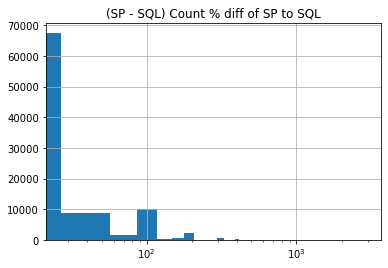

In [13]:
df_sp_sql_group_by_plus_counts_and_stats_nans_removed = df_sp_sql_group_by_plus_counts_and_stats.dropna()
print (len(df_sp_sql_group_by_plus_counts_and_stats_nans_removed))
fig, ax = plt.subplots()

df_sp_sql_group_by_plus_counts_and_stats_nans_removed.hist(column = '(SP - SQL) Count % diff of SP to SQL', bins = 100, ax = ax)
ax.set_xscale('log')
print (max(df_sp_sql_group_by_plus_counts_and_stats_nans_removed['(SP - SQL) Count % diff of SP to SQL']))
print (df_sp_sql_group_by_plus_counts_and_stats_nans_removed['(SP - SQL) Count % diff of SP to SQL'].value_counts())

In [14]:
print (63425/111897)

0.5668159110610651


Around 57% of the delivery line data matches exactly, in count per month, compared to Johan's dataset. 

In [15]:

print (max(df_sp_sql_group_by_plus_counts_and_stats_nans_removed['(SP - SQL) OQ % diff of SP to SQL']))
print (df_sp_sql_group_by_plus_counts_and_stats_nans_removed['(SP - SQL) OQ % diff of SP to SQL'].value_counts())

inf
 0.000000      56887
 100.000000    3012 
-50.000000     1320 
 50.000000     926  
 200.000000    663  
              ...   
-52.482270     1    
 35.593220     1    
 15.174507     1    
 1.282051      1    
 89.020772     1    
Name: (SP - SQL) OQ % diff of SP to SQL, Length: 20434, dtype: int64


In [16]:
print (56887/111897)

0.5083871774935879


Only 51% match on order quantity. That's disappointing. Check some lines manually. 

## Check data manually, less matched for delivery lines

In [17]:
df_sp_sql_group_by_plus_counts_and_stats_shuffled = df_sp_sql_group_by_plus_counts_and_stats.sample(frac=1)
df_sp_sql_group_by_plus_counts_and_stats_shuffled.head()

,SalesOrderDeliveryLineCreationDate,MaterialNo,SQL_counts,SQL_OQ,S_P_Count,S_P_Consumption,(SP - SQL) Count,(SP - SQL) OQ,(SP - SQL) Count % diff of SP to SQL,(SP - SQL) OQ % diff of SP to SQL
170434,2019-04-01,10008915,1.0,20.0,1.0,20.0,0.0,0.0,0.0,0.0
156247,2019-02-01,12168519,11.0,38800.0,NaN,NaN,NaN,NaN,NaN,NaN
290089,2020-03-01,10027267,6.0,1990.0,NaN,NaN,NaN,NaN,NaN,NaN
156932,2019-02-01,12497428,1.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN
144912,2019-01-01,12094570,6.0,550.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_sp_order_quantities_shuffled = df_sp_order_quantities.sample(frac=1)
df_sp_order_quantities_shuffled.head()

,Article,Orders_03_19,Orders_04_19,Orders_05_19,Orders_06_19,Orders_07_19,Orders_08_19,Orders_09_19,Orders_10_19,Orders_11_19,Orders_12_19,Orders_01_20,Orders_02_20,Consumption_Total_03_19,Consumption_Total_04_19,Consumption_Total_05_19,Consumption_Total_06_19,Consumption_Total_07_19,Consumption_Total_08_19,Consumption_Total_09_19,Consumption_Total_10_19,Consumption_Total_11_19,Consumption_Total_12_19,Consumption_Total_01_20,Consumption_Total_02_20
7139,10023999,4,4,1,NaN,2,1,2,2,3,2,1,NaN,116,13,50,NaN,60,10,126,150,12,56,10,NaN
23720,12491428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13169,10064017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,000",NaN,NaN,NaN
22578,12438157,NaN,1,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,1,NaN,"4,000",NaN,NaN,NaN,NaN,NaN,"4,000","4,000",NaN,NaN,"4,000"
20557,12093038,1,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,1,400,NaN,NaN,400,NaN,NaN,NaN,NaN,400,NaN,NaN,400


In [19]:
df_sp_sql.head()

,MaterialNo,DeliveryBaseUnitQuantity,SalesOrderDeliveryLineCreationDate
0,11938131,1.0,2018-11-16
1,10014239,1.0,2019-02-01
2,11295548,1.0,2019-04-04
3,10020294,1.0,2019-09-05
4,10028242,1.0,2019-08-02


Three stages:
1. Check directly in TED  
    a. TED VPN broken, use df_sp_sql instead, just as good for now  
2. Check df_sp_sql_group_by_plus_counts_and_stats_shuffled
3. Check df_sp_order_quantities_shuffled

10012984:

In [20]:
df_sp_sql_10012984 = df_sp_sql[df_sp_sql['MaterialNo'] == '10012984']
df_sp_sql_10012984 = df_sp_sql_10012984.sort_values(by='SalesOrderDeliveryLineCreationDate',ascending=True)
df_sp_sql_10012984.head(50)

,MaterialNo,DeliveryBaseUnitQuantity,SalesOrderDeliveryLineCreationDate
465098,10012984,1.0,2018-05-28
465066,10012984,1.0,2019-01-04
180811,10012984,3.0,2019-02-12
180874,10012984,2.0,2019-07-01
885617,10012984,1.0,2019-07-03
195265,10012984,4.0,2019-10-09
464984,10012984,5.0,2019-12-05
886428,10012984,7.0,2020-10-05
887095,10012984,5.0,2020-10-05
912237,10012984,3.0,2020-11-30


In [21]:
df_sp_sql_group_by_plus_counts_and_stats_shuffled_10012984 = df_sp_sql_group_by_plus_counts_and_stats_shuffled[df_sp_sql_group_by_plus_counts_and_stats_shuffled['MaterialNo'] == '10012984']
df_sp_sql_group_by_plus_counts_and_stats_shuffled_10012984 = df_sp_sql_group_by_plus_counts_and_stats_shuffled_10012984.sort_values(by='SalesOrderDeliveryLineCreationDate',ascending=True)
df_sp_sql_group_by_plus_counts_and_stats_shuffled_10012984.head(50)

,SalesOrderDeliveryLineCreationDate,MaterialNo,SQL_counts,SQL_OQ,S_P_Count,S_P_Consumption,(SP - SQL) Count,(SP - SQL) OQ,(SP - SQL) Count % diff of SP to SQL,(SP - SQL) OQ % diff of SP to SQL
48437,2018-05-01,10012984,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
137000,2019-01-01,10012984,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
148454,2019-02-01,10012984,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
203601,2019-07-01,10012984,2.0,3.0,1.0,1.0,-1.0,-2.0,-50.0,-66.666667
235537,2019-10-01,10012984,1.0,4.0,1.0,4.0,0.0,0.0,0.0,0.000000
256762,2019-12-01,10012984,1.0,5.0,1.0,5.0,0.0,0.0,0.0,0.000000
357440,2020-10-01,10012984,2.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
367217,2020-11-01,10012984,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_sp_order_quantities_shuffled_10012984 = df_sp_order_quantities_shuffled[df_sp_order_quantities_shuffled['Article'] == '10012984']
df_sp_order_quantities_shuffled_10012984.head(50)

,Article,Orders_03_19,Orders_04_19,Orders_05_19,Orders_06_19,Orders_07_19,Orders_08_19,Orders_09_19,Orders_10_19,Orders_11_19,Orders_12_19,Orders_01_20,Orders_02_20,Consumption_Total_03_19,Consumption_Total_04_19,Consumption_Total_05_19,Consumption_Total_06_19,Consumption_Total_07_19,Consumption_Total_08_19,Consumption_Total_09_19,Consumption_Total_10_19,Consumption_Total_11_19,Consumption_Total_12_19,Consumption_Total_01_20,Consumption_Total_02_20
3976,10012984,NaN,NaN,NaN,1,1,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,2,1,NaN,NaN,4,NaN,5,NaN,NaN


10025098:

In [23]:
df_sp_sql_10025098 = df_sp_sql[df_sp_sql['MaterialNo'] == '10025098']
df_sp_sql_10025098 = df_sp_sql_10025098.sort_values(by='SalesOrderDeliveryLineCreationDate',ascending=True)
df_sp_sql_10025098.head(50)

,MaterialNo,DeliveryBaseUnitQuantity,SalesOrderDeliveryLineCreationDate
620813,10025098,50.0,2018-01-23
806249,10025098,2.0,2018-03-21
826295,10025098,2.0,2018-06-04
145828,10025098,3.0,2018-06-19
364591,10025098,10.0,2018-09-05
197778,10025098,50.0,2018-09-19
681830,10025098,10.0,2018-11-19
510404,10025098,50.0,2019-03-06
76453,10025098,6.0,2019-03-19
720969,10025098,50.0,2019-03-22


In [24]:
df_sp_sql_group_by_plus_counts_and_stats_shuffled_10025098 = df_sp_sql_group_by_plus_counts_and_stats_shuffled[df_sp_sql_group_by_plus_counts_and_stats_shuffled['MaterialNo'] == '10025098']
df_sp_sql_group_by_plus_counts_and_stats_shuffled_10025098 = df_sp_sql_group_by_plus_counts_and_stats_shuffled_10025098.sort_values(by='SalesOrderDeliveryLineCreationDate',ascending=True)
df_sp_sql_group_by_plus_counts_and_stats_shuffled_10025098.head(50)

,SalesOrderDeliveryLineCreationDate,MaterialNo,SQL_counts,SQL_OQ,S_P_Count,S_P_Consumption,(SP - SQL) Count,(SP - SQL) OQ,(SP - SQL) Count % diff of SP to SQL,(SP - SQL) OQ % diff of SP to SQL
4383,2018-01-01,10025098,1.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
27300,2018-03-01,10025098,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
62819,2018-06-01,10025098,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
96584,2018-09-01,10025098,2.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN
118906,2018-11-01,10025098,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
161891,2019-03-01,10025098,3.0,106.0,3.0,106.0,0.0,0.0,0.0,0.0
173233,2019-04-01,10025098,1.0,1000.0,1.0,1000.0,0.0,0.0,0.0,0.0
237764,2019-10-01,10025098,1.0,70.0,1.0,70.0,0.0,0.0,0.0,0.0
258691,2019-12-01,10025098,1.0,50.0,1.0,50.0,0.0,0.0,0.0,0.0
289557,2020-03-01,10025098,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_sp_order_quantities_shuffled_10025098 = df_sp_order_quantities_shuffled[df_sp_order_quantities_shuffled['Article'] == '10025098']
df_sp_order_quantities_shuffled_10025098.head(50)

,Article,Orders_03_19,Orders_04_19,Orders_05_19,Orders_06_19,Orders_07_19,Orders_08_19,Orders_09_19,Orders_10_19,Orders_11_19,Orders_12_19,Orders_01_20,Orders_02_20,Consumption_Total_03_19,Consumption_Total_04_19,Consumption_Total_05_19,Consumption_Total_06_19,Consumption_Total_07_19,Consumption_Total_08_19,Consumption_Total_09_19,Consumption_Total_10_19,Consumption_Total_11_19,Consumption_Total_12_19,Consumption_Total_01_20,Consumption_Total_02_20
8037,10025098,3,1,NaN,NaN,NaN,NaN,NaN,1,NaN,1,1,1,106,"1,000",NaN,NaN,NaN,NaN,NaN,70,NaN,50,1,0


I spoke to Hans and Anil today. Hans said that he looked over Johan's dataset, and it doesn't seem to match very well with the demand that Slim4 sees. I think we'll have to use the MSEG data instead. Anil is preparing it, it's around 5-8 million rows, so needs to be divided up into many files. We'll then filter this file based on a certain set of SKUs from the forecasts dataset. This is done in Notebook 8. 